# Simulating flows

In this recitation, we will work towards a better understanding about how to simulating the movement of particles on a discrete flow field. In particular, this will be helpful for the section project where you will be asked to use simulation of particle movement on oceanic data presented in the form of discrete flow fields.

- **Disclaimer 1:** This is by no means, a comprehensive study of computational fluid dynamics. To the interested reader please see: Stam, Jos. **"Stable fluids."** in the *Proceedings of the 26th Annual Conference on Computer graphics and Interactive Techniques 1999*. Another great source for fluid simulations can be found in https://www.karlsims.com/flow.html
- **Disclaimer 2:** In this recitation, we will work only on 2-dimensional spaces. However, the techinques and procedues can be extended to other spaces.
- **Disclaimer 3:** We will initially focus on the movement of a single particle. For simulating multiple non-interacting particles the process scales similarly. We do not consider interacting particles.

## What is a flow?
A flow refers to displacement in time, that is if $x(t)$ denotes the location of a particle at time $t$. Then, we define the flow vector as
\begin{equation}
 \frac{d x(t)}{dt}= V(x(t),t).
\end{equation}
or similarly, their explicit Euler discretization as, for a small $\varepsilon > 0$ , then
\begin{equation}
  x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t).
\end{equation}

Informally, if we know the position of a particle at time $t$, then, after some arbitrarily small time $\varepsilon$, that is, at time $t+\varepsilon$, we can compute the new position $x(t+\varepsilon)$ as $x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t)$, assuming we know the flow information coded in the function $V(x(t),t)$.

The next figure shows a simple flow system with four points, shown as white circles. Each point corresponds to a physical location also shown in kilometers. Attached to each point is a flow data point, which is shown as a blue arrow. Recall that flow data is given in the $x$ and $y$ direction. It is assumed that a particle moving in one of the zones or boxes acquires the velocity given by the flow data.

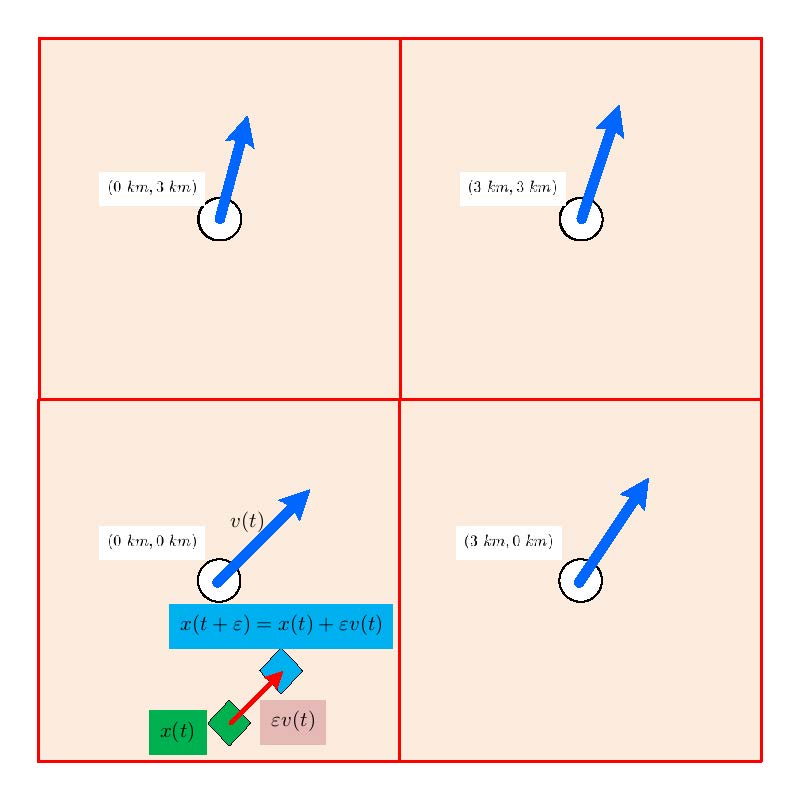

This example shows that at time $t$, a particle is located at a position $x(t)$, shown as a green diamond. After some time $\varepsilon$ has passed, at time $t+\varepsilon$, the particle is at a new location $x(t+\varepsilon)$ shown as a blue diamond. The new location can be computed as the previous location $x(t)$ plus a time displacement computed as the change in time $\varepsilon$ times the velocity at that point $v(t)$.  Note that the velocity is given in distance units per time unit, for example, kilometers per hour. Thus, the location $x(t)$ must be given in the same distance units, e.g., kilometers, and the time displacement $\varepsilon$ should be given in hours.

### The ingredients for simulating a flow:

As noted by the description above, in order to simulate the movement of the particle we need a couple of items:
- A space $\mathcal{X}$ where we want out simulation to be run on. For example for a 2-dimensional space, we can consider a box with unitary lenght, i.e., $\mathcal{X}=[0,1]\times[0,1]$.
- An initial position $x(0)\in\mathcal{X}$. Of course we want our initial position to be inside the space we want to simulate the movement.
- A simulation time $T$. This is the maximum time we would like to run our simulation.
- A time step $T\geq\varepsilon>0$. The unit $\varepsilon$ is going to serve as a discretization of time, and is going to the the smallest unit of time we are going to consider in our simulation. In practice, this means our simulation should output a sequence of positions for times $\{0,\varepsilon,2\varepsilon,3\varepsilon,4\varepsilon,\ldots,T\}$.
- The number $\varepsilon$ also defines the number of iterations we are going to have in our simulation. For example, if $T=10$, and $\varepsilon=2$, then we will run a total of $N=5$ iterations. One can start the oposite direction, by defining the number of iterations first and then compute the corresponding time step. For example, if I want to run $N=300$  iterations, I will have to set \begin{equation} \varepsilon = \frac{T}{N} = \frac{10}{300} \approx 0.033.\end{equation}
- A flow function $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$. This function has two input arguments, namely, a position $x(t)$ and a time $t$, and outputs a vector in $\mathbb{R}^2$ which indicates the velocity that a particle at location $x(t)$ would have in the $x$ and $y$ axis respectively. Note that we have explicitly allowed the flow function to depend on time. That is, flows might change depending not only on the location but of the time index.
- In general, we might not have access to a generic function of the form $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$, specially if our flow comes from data that has been obtained at some particular set of locations. In this case, we might consider a set $\mathcal{G} = \{x_1, x_2, \ldots, x_m\}$ where $x_i\in\mathcal{X}$ for $i\in\{1,2,\ldots,m\}$. These points represents the locations where flow information is available. For simulation purposes in this case, if at some point in time $t \in [0, T]$, the particle is at a location $x(t)$, instead of using the flow $V(x(t),t)$ which might not be available, we will use the surrogate flow $V(x_j,t)$ where $x_j = \mathrm{argmin}_{z\in\mathcal{G}} \;d(z, x(t))$ where $d(\cdot,\cdot)$ is some distance function, for example $d(x,y) = \|x - y\|^2$. This indicates that we will use the flow information at a point $x_j$ in the set of available locations, that is closest to $x(t)$ in some predefined sense.

Next, we will create a sequence of increasingly complex sample codes that will helps us better understand the simulation process.

## Example 1: A particle on a constant flow field.

In this example, we are going to simulate the movement of a single particle in a box with unit length. Moreover, we are going to assume the velocity information or the flow data is constant on this box. You will be able to set the maximum time of the simulation, the number of steps, the initial position of the particle. and the velocity of the flow in the $x$ and $y$ axis.

In [ ]:
import numpy as np

T = 4.0 #@param {type:"number"}
N = 50 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
v = 0.5 * np.random.rand(2) - 0.25

g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v[:, None, None]

In [ ]:
import matplotlib.pyplot as plt

def flowplot(ax, loc, grid_x, grid_y, fl_x, fl_y, title, overlay=None):
  sc = ax.scatter(loc[0], loc[1], marker='o')
  ax.set_xlabel(r"$x$-axis")
  ax.set_ylabel(r"$y$-axis")
  ax.axis([0, 1, 0, 1])
  ax.set_title(title)
  qv = ax.quiver(grid_x, grid_y, fl_x, fl_y)
  if overlay:
    overlay(ax)
  def update(new_loc, new_fl = None, new_title=None):
    sc.set_offsets(new_loc)
    if new_title:
      ax.set_title(new_title)
    if new_fl:
      qv.set_UVC(*new_fl)
      return sc, qv
    else:
      return sc,
  return update

flowplot(plt.gca(), x_0, g_x, g_y, w_x, w_y, r"A particle on a constant flow field2. $T = 0$.")
plt.show()

In [ ]:
xs = [(x_0, 0)]
t = 0
for _ in range(N):
  x = xs[-1][0] + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break

  xs.append((x,t))

import matplotlib.animation as anim
from matplotlib import rc
rc('animation', html='jshtml')

fig, ax = plt.subplots()
update_plot = flowplot(ax, x_0, g_x, g_y, w_x, w_y, r"A particle on a constant flow field2. $T = 0$.")

def frame(x):
  return update_plot(x[0], new_title=r"A particle on a constant flow field2. $T = {:.2f}$.".format(x[1]))

animation = anim.FuncAnimation(fig, frame, frames=xs, blit=True)
plt.close()

In [ ]:
animation

## Example 2: A particle on an oscillating field

As a second example, we will assume that the velocities of the flow in the $x$ and $y$ axis follow an oscillating behaviour, with certain frequency.

In [ ]:
f = 2 #@param {type:"slider", min:0.5, max:10, step:0.5}
T = 2.0 #@param {type:"number"}
N = 100 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
t = np.arange(0, T, epsilon) # Create the vector of times
v_x = np.sin(2*np.pi*f*t) # Compute the velocity values at every time instant
v_y = np.cos(2*np.pi*f*t) # Compute the velocity values at every time instant

# Plot the velocities
plt.subplot(211)
plt.plot(t,v_x)
plt.xlabel('time')
plt.ylabel('x-axis velocity')
plt.title('Velocity in the x-axis')
plt.subplot(212)
plt.plot(t,v_y)
plt.xlabel('time')
plt.ylabel('x-axis velocity')
plt.title('Velocity in the x-axis')
plt.show()

# Create a Mesh for showing the flow data
g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2),np.arange(0, 1.1, 0.2))
v_0 = np.array([v_x[0], v_y[0]])
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v_0[:, None, None]

flowplot(plt.gca(), x_0, g_x, g_y, w_x, w_y, r"A particle on an oscillating flow field. $T = 0$.")
plt.show()

state = [(x_0, 0, v_0, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break

  v = np.array([v_x[i], v_y[i]])
  state.append(
      (x, t, v)
      + tuple(np.ones(g_x.shape)[None, :, :] * v[:, None, None])
      )
  
def animate(state, g_x, g_y, title, overlay=None):
  fig, ax = plt.subplots()
  x_0, t_0, v_0, fl_x, fl_y = state[0]
  update_plot = flowplot(ax, x_0, 
                         g_x, g_y, 
                         fl_x, fl_y, 
                         title.format(t_0),
                         overlay)

  def frame(s):
    x, t, v, fl_x, fl_y = s
    return update_plot(x,
                      new_fl = (fl_x, fl_y), 
                      new_title=title.format(t))

  animation = anim.FuncAnimation(fig, frame, frames=state, blit=True)
  plt.close()
  return animation
animate(state, g_x, g_y, r"A particle on an oscillating flow field. $T = {:.2f}$.")

## Example 3:  A particle on a random velocity field

In this simulation, we will assume that the velocity changes with time as a realization of a uniform random variable on the range $[-1,1]$. However, contrary to Example 2, the changes do not happen at every iteration. But only every 0.3 units of time. So we need to take care of that.

In [ ]:
T = 2.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
t = np.arange(0, T, epsilon) # Create the vector of times

g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2),np.arange(0, 1.1, 0.2))
v_0 = np.random.rand(2) - 0.5
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v_0[:, None, None]

state = [(x_0, 0, v_0, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break

  if i % int(0.3/epsilon) == 0:
    v = np.random.rand(2) - 0.5
  
  state.append(
      (x, t, v)
      + tuple(np.ones(g_x.shape)[None, :, :] * v[:, None, None])
      )
animate(state, g_x, g_y, r"A particle on a time-varying random flow field. $T = {:.2f}$.")

##Exercise 4: Multiple particles in a random across time velocity field

In this exercose, we repeat the setup of Exercise 3, with the main difference of simulating several particles at once.

In [ ]:
T = 2.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
num = 20 #@param {type:"integer"}
epsilon = T/N

x_0 = 0.5*np.random.rand(num, 2) + 0.25
t = np.arange(0, T, epsilon) # Create the vector of times

g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2),np.arange(0, 1.1, 0.2))
v_0 = np.random.rand(2) - 0.5
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v_0[:, None, None]

state = [(x_0, 0, v_0, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  if i % int(0.3/epsilon) == 0:
    v = np.random.rand(2) - 0.5
  
  state.append(
      (x, t, v)
      + tuple(np.ones(g_x.shape)[None, :, :] * v[:, None, None])
      )
animate(state, g_x, g_y, r"Many particles on a time-varying random flow field. $T = {:.2f}$.")

## Exercise 5: One particle over four regions with different flows but constant over time

Up to now, all previous exercises work under the case that the velocity field is constant acroos the space $\mathcal{X}$. We have allowed changes across time, but the flow was the same at every point in the space. In the next couple of exercises, we are going to study what happens if we allow for the flow to be different at different regions in the space. You will see this case explicitly in the project, where you will be given flow information for a number of locations, and such flows change over the space.

Initially, consider that we partition our unitary square into four regions as shown below.

In [ ]:
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0.5, 0.5], [0, 1], c='r', lw=2)
plt.plot([0, 0], [0, 1], c='r', lw=2)
plt.plot([1, 1], [0, 1], c='r', lw=2)
plt.plot([0, 1], [0.5, 0.5], c='r', lw=2)
plt.plot([0, 1], [0, 0], c='r', lw=2)
plt.plot([0, 1], [1, 1], c='r', lw=2)
plt.text(0.25,0.25,'Region 1')
plt.text(0.75,0.25,'Region 2')
plt.text(0.25,0.75,'Region 3')
plt.text(0.75,0.75,'Region 4')
plt.show()

Moreover, we will assume the flow in each of the regious is different. For example

In [ ]:
g_x, g_y = np.meshgrid(np.arange(0.05, 1, 0.1),np.arange(0.05, 1, 0.1))
v_0_grid = 0.5*np.random.rand(2,2,2) - 0.25
w_x, w_y = np.repeat(np.repeat(v_0_grid, g_x.shape[0]//2, axis=2), g_x.shape[0]//2, axis=1)

plt.quiver(g_x, g_y, w_x, w_y)
plt.show()

Now, let's simulate the movement of a particle in a flow that is partitioned in those four regions described above. The main trick now is that we need to see in what region the particle is before computing the next position.

In [ ]:
T = 2.0 #@param {type:"number"}
N = 100 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
t = np.arange(0, T, epsilon) # Create the vector of times

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  v = v_0_grid[:,int(x[1]>0.5),int(x[0]>0.5)]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break
  
  state.append(
      (x, t, v)
      + tuple(np.repeat(np.repeat(v_0_grid, g_x.shape[0]//2, axis=2), g_x.shape[0]//2, axis=1))
      )
animate(state, g_x, g_y, r"A particle on a time-contant regional flow field. $T = {:.2f}$.")

## Exercise 6: One particle on a generic $m\times m$ grid with constant flows over time
In Exercise 5, we have simulated the movement of one particle on a 2 by 2 grid. In this exercise, we will do so for generic grid of $m$ by $m$ regions.

In [ ]:
T = 2.0 #@param {type:"number"}
N = 100 #@param {type:"integer"}
m = 20 #@param {type:"slider", min:0, max:20, step:1}
epsilon = T/N

x_0 = np.random.rand(2)
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, 1, m+1, endpoint=True)
g_y_edges = np.linspace(0, 1, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
v_0_grid = 0.4*np.random.rand(2,m,m) - 0.2
w_x, w_y = v_0_grid

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  vi = np.searchsorted(g_x_edges, x[1])
  vj = np.searchsorted(g_y_edges, x[0])
  v = v_0_grid[:,vi-1,vj-1]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break
  
  state.append(
      (x, t, v) + tuple(v_0_grid)
      )
animate(state, g_x, g_y, r"A particle on a time-constant regional flow field. $T = {:.2f}$.")

## Exercise 7: Multiple particles on a generic $m\times m$ grid with constant flows over time

In [ ]:
T = 2.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
num = 30 #@param {type:"integer"}
m = 20 #@param {type:"slider", min:0, max:20, step:1}
epsilon = T/N

x_0 = np.random.rand(num, 2)
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, 1, m+1, endpoint=True)
g_y_edges = np.linspace(0, 1, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
v_0_grid = 0.4*np.random.rand(2,m,m) - 0.2
w_x, w_y = v_0_grid

# We will use this to extend the velocity field outside of the [0,1] range.
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  vi = clamp(np.searchsorted(g_x_edges, x[:,1]), 1, m)
  vj = clamp(np.searchsorted(g_y_edges, x[:,0]), 1, m)
  v = v_0_grid[:,vi-1,vj-1].T
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time
  
  state.append(
      (x, t, v) + tuple(v_0_grid)
      )
animate(state, g_x, g_y, r"Many particles on a time-constant regional flow field. $T = {:.2f}$.")

## Exercise 8: Multiple particles on a generic  grid on a flow that changes with time

This case is very similar as Exercise 7, with the main difference that we will allowe changes in the flows from time to time. Especifically we change the flows every 0.5 units of time


In [ ]:
T = 2.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
num = 30 #@param {type:"integer"}
m = 20 #@param {type:"slider", min:0, max:20, step:1}
epsilon = T/N

x_0 = np.random.rand(num, 2)
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, 1, m+1, endpoint=True)
g_y_edges = np.linspace(0, 1, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
v_0_grid = 0.4*np.random.rand(2,m,m) - 0.2
w_x, w_y = v_0_grid

# We will use this to extend the velocity field outside of the [0,1] range.
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  vi = clamp(np.searchsorted(g_x_edges, x[:,1]), 1, m)
  vj = clamp(np.searchsorted(g_y_edges, x[:,0]), 1, m)
  v = v_0_grid[:,vi-1,vj-1].T
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time
  
  state.append(
      (x, t, v) + tuple(v_0_grid)
      )

  if i % (0.5//epsilon) == 0:
    v_0_grid = 0.4*np.random.rand(2,m,m) - 0.2
  
animate(state, g_x, g_y, r"Many particles on a time-varying random regional flow field. $T = {:.2f}$.")

## Exercise 9: Working with realistic time and space units.

In this exercise, we are going to replicate Exercise 8, however, we will focus on the case where you are given specific time and space units to work on.

Initially, suppose you are asked to simulate the movement of particles on a flow that changes with time. The initial locations of these particles are distributed according to some Gaussian distribution. The main objective is to estimate the likely positions of these particles after a long time.

We will work on a toy example where we are focused on an area of 1km by 1km.  In this area, there are both parts covered by water and parts covered by land. You can imagine an ocean and some parts of land as shown in the figure below. Where the red dots indicate the location of the sensors where you can obtain flow velocity measurements.

We have a recording of the flow velocity in both the $x$ and $y$ directions at each location of the sensor, i.e., the red dots, once every 30 days, for a total period of 200 days.

In [ ]:
T = 200.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
num = 30 #@param {type:"integer"}
m = 10 #@param {type:"slider", min:0, max:20, step:1}
epsilon = T/N # days
scale = 1000 # meters

x_0 = scale*(np.random.rand(num, 2)*np.array([1, 0.8]) + np.array([0, 0.2]))
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, scale, m+1, endpoint=True)
g_y_edges = np.linspace(0, scale, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
def generate_v0(m, g_x, g_y):
  v = np.array([
                    -4*np.random.rand(m, m),
                    -4*np.random.rand(m, m) + 2 - 0.01*(g_y-800)
  ])
  v[:, g_y[:,0] < 100, :] = 0
  return v
v_0_grid = generate_v0(m, g_x, g_y)
w_x, w_y = v_0_grid

def plot_overlay(ax):
  import matplotlib.patches
  ax.scatter(g_x, g_y, marker='o', c='r')
  ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1000, 100, edgecolor='k', facecolor='orange'))
  ax.text(scale*0.5,scale*0.05,'Land')
  ax.text(scale*0.5,scale*0.5,'Sea')
  ax.axis([0, 1000, 0, 1000])

# We will use this to extend the velocity field outside of the [0,1000] range.
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  vi = clamp(np.searchsorted(g_x_edges, x[:,1]), 1, m)
  vj = clamp(np.searchsorted(g_y_edges, x[:,0]), 1, m)
  v = v_0_grid[:,vi-1,vj-1].T
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time
  
  state.append(
      (x, t, v) + tuple(v_0_grid)
      )
  
  if i % 30 == 0:
    v_0_grid = generate_v0(m, g_x, g_y)
  
animate(state, g_x, g_y, r"Many particles on a time-varying random flow field. Day $ = {:.2f}$.", overlay=plot_overlay)

## Bonus Exercise: Simulating with JAX

For large $N$, iterating through a Python `for` loop can be slow. To speed things up, we can use Google's JAX library.

JAX performs a "Just In Time" (JIT) compilation of a python function to a fast internal language of linear algebra primitives. This library is most often used in machine learning, but can be used for anything numerical in Python.

Below is an example, similar to Exercise 9, but with an added oscillation time variation. The main point of the exercise is to compare the performance of pure Python to JAX.

In [ ]:
T = 2000.0 #@param {type:"number"}
N = 200000 #@param {type:"integer"}
num = 3000 #@param {type:"integer"}
m = 10 #@param {type:"slider", min:0, max:20, step:1}
f = 0.0025 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}
epsilon = T/N # days
scale = 1000 # meters

x_0 = scale*(np.random.rand(num, 2)*np.array([1, 0.8]) + np.array([0, 0.2]))
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, scale, m+1, endpoint=True)
g_y_edges = np.linspace(0, scale, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
def generate_v0(m, g_x, g_y, f, t):
  v = np.array([
                    -np.random.rand(m, m),
                    -np.random.rand(m, m) + 0.5 - 0.005*(g_y-800)
  ])
  v = v[None, :, :, :] + 0.5*np.array([ np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t) ]).T[:, :, None, None]
  v[:, :, g_y[:,0] < 100, :] = 0
  return v
v_0_grid = generate_v0(m, g_x, g_y, f, t)


def plot_overlay(ax):
  import matplotlib.patches
  ax.scatter(g_x, g_y, marker='o', c='r')
  ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1000, 100, edgecolor='k', facecolor='orange'))
  ax.text(scale*0.5,scale*0.05,'Land')
  ax.text(scale*0.5,scale*0.5,'Sea')
  ax.axis([0, 1000, 0, 1000])

# We will use this to extend the velocity field outside of the [0,1000] range.
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

# The Python look is encapsulated in a function so that we can time it.
def python_sim(save_stride=1):
  states = []
  state = (x_0, 0, None, None, None)
  for i in range(N):
    x, t, v, _, _ = state

    vi = clamp(np.searchsorted(g_x_edges, x[:,1]), 1, m)
    vj = clamp(np.searchsorted(g_y_edges, x[:,0]), 1, m)
    v = v_0_grid[i][:,vi-1,vj-1].T
    
    x = x + epsilon*v # Compute the next position value
    t = t + epsilon # Compute the next time
    
    state = (x, t, v) + tuple(v_0_grid[i])

    # If we saved every iteration, we would soon run out of memory, and
    # it would take a very long time to generate the animation.
    # Here, the state is only saved for later display once every save_stride
    # iterations.
    if i % save_stride == 0:
      states.append(state)
  return states
  
%time states = python_sim(N//100)

Now we define a equivalent function but using JAX.

Note that JAX can only accelerate operations performed using its own clone of the numpy interface through `jax.numpy`.

In [ ]:
import jax.numpy as jnp
import jax
import functools

# This declares that this entire function should be compiled.
# Most arguments to the function can be altered after compilation, but a few,
# N and save_stride, determine the number of iterations that we take and need
# to be baked into the compiled version. These are marked as "static", see the
# JAX documentation for more information of why and where this is neccessary.
@functools.partial(jax.jit, static_argnums=(0,1))
def jax_sim(N, save_stride, m, g_x_edges, g_y_edges, v_0_grid, x_0, epsilon):

  # We must reimplement this using jax.numpy
  clamp = lambda ar, min_, max_: jnp.maximum(min_, jnp.minimum(max_, ar))

  # The indexing operations also need to written using jax.numpy
  def get_v(grid, x):
    vi = clamp(jnp.searchsorted(g_x_edges, x[:,1]), 1, m)
    vj = clamp(jnp.searchsorted(g_y_edges, x[:,0]), 1, m)
    return grid[:,vi-1,vj-1].T

  # We can't change the shape of elements of a tuple mid way through a JAX loop
  # so we have to set up all elements here with the same array shapes as they
  # will use for the final product (i.e. no None values).
  state_0 = (x_0, 0.0, get_v(v_0_grid[0], x_0), *v_0_grid[i])
  
  # Rather than use a for loop, we write the body of the loop in terms of a
  # function, and then pass it to JAX to perform the loop. Because we only
  # wish to save some of the results, we will need two nested loops.

  # The inner loop body, defined here, handles taking one step, or iteration,
  # of the simulation. Note that is takes the current state as a parameter,
  # then returns the new state.
  def step(i, state):
    x, t, v, _, _ = state

    v = get_v(v_0_grid[i], x)
    
    x = x + epsilon*v # Compute the next position value
    t = t + epsilon # Compute the next time
    
    new_state = (x, t, v) + tuple(v_0_grid[i])
    return new_state

  # The outer loop body
  def save_step(state, i):
    # Within this outer loop, jax.lax.fori_loop is called with the inner loop
    # body in order to perform the inner loop.
    # fori_loop passes the return value from the pervious iteration as the
    # parameter for the next one. It then returns the result of the last
    # iteration
    new_state = jax.lax.fori_loop(i, i+save_stride, step, state)
    return new_state, new_state
  
  # jax.lax.scan is similar to fori_loop, but it also saves one of the return
  # values of the function to an array. So we use lax.scan for the outer loop
  # so as to save the values, and lax.fori_loop for the inner.
  _, states = jax.lax.scan(save_step, state_0, xs=jnp.arange(0, N, save_stride))
  return states

%time jax_states = jax_sim(N, N//100, m, g_x_edges, g_y_edges, v_0_grid, x_0, epsilon)

We can see that the JAX implementation is significantly faster.

In [ ]:
# JAX can't store arrays of tuples, so it stores them as tuples of arrays instead
# Thus, we need to 'transpose' this tuple to create a list of tuples as the animate
# function expects.
display_states = list(zip(*jax_states))
#display_states = states # Uncomment this to compare to the pure Python implementation.
animate(display_states, g_x, g_y, r"Jax example. Day $= {}$.", overlay=plot_overlay)